In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Seaborn style settings
sns.set_theme(style="ticks", palette="mako")

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


In [3]:
# Melting
master_df = pd.melt(master_df,
                    value_vars=[
                    "Vancouver_Clark_Drive_PM25",\
                    "Vancouver_International_Airport_#2_PM25",\
                    "North_Vancouver_Mahon_Park_PM25",\
                    "North_Vancouver_Second_Narrows_PM25"
                    ],
                    ignore_index=False).rename(columns={
                    "variable": "Station",
                    "value": "PM 2.5"})
display(master_df.head())
print(master_df.shape)

,Station,PM 2.5
DATE_PST,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336


(228056, 2)


In [4]:
# Dummy variable to keep track of missing samples and missing sample length
master_df["MISSING"] = np.where(master_df["PM 2.5"].isnull(), 1, 0)
master_df.head()

,Station,PM 2.5,MISSING
DATE_PST,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0


In [5]:
# Total missing values
master_df["MISSING"].sum()

4958

In [6]:
# List of stations
stations = master_df["Station"].unique().tolist()
stations

['Vancouver_Clark_Drive_PM25',
 'Vancouver_International_Airport_#2_PM25',
 'North_Vancouver_Mahon_Park_PM25',
 'North_Vancouver_Second_Narrows_PM25']

In [7]:
# Isolating stations on independent dataframes
datasets = {}
for station in stations:
    datasets[station] = master_df[master_df["Station"] == station]
    datasets[station] = datasets[station][["PM 2.5", "MISSING"]]
    datasets[station].reset_index(inplace=True)

del master_df
datasets.keys()

dict_keys(['Vancouver_Clark_Drive_PM25', 'Vancouver_International_Airport_#2_PM25', 'North_Vancouver_Mahon_Park_PM25', 'North_Vancouver_Second_Narrows_PM25'])

In [8]:
# Identifying isolated missing values and continuous missing values
# Auxiliar column to identify missing value interval lengths
for station in stations:
    # Initialize missing value sequency array and maximum sequence length
    nan_seq_length = np.zeros(len(datasets[station]))
    seq_max = 0
    for i in range(0, len(datasets[station])):
        seq = 0  # Sequence counter
        if not datasets[station].loc[i, "MISSING"]:
            breakpoint = (
                i - 1
            )  # Store previous id when entering a missing value sequence
        while datasets[station].loc[i, "MISSING"]:
            i += 1  # Add up to iterator while still missing
            seq += 1  # Add up to sequence length while still missing
        if seq:  # Check if in a missing sequence
            if seq_max < seq:  # If max sequence length < current sequence
                seq_max = seq  # Update maximum sequence length
        else:
            seq_max = 0  # If not in a missing sequence reset max sequence lenght
        # Update sequence length array with maximum sequence length
        nan_seq_length[(i - seq)] = seq_max
    datasets[station]["MISSING_SEQ"] = nan_seq_length.astype(int)

In [9]:
# Recomposing Master DataFrame
master_df = pd.concat(datasets).reset_index(level=0)

# Renaming station column
master_df["STATION"] = master_df["level_0"]
master_df = master_df[["DATE_PST", "STATION", "PM 2.5", "MISSING", "MISSING_SEQ"]]
# master_df.drop("level_0", axis=1, inplace=True)

# Redefining DATE_PST index
master_df.set_index("DATE_PST", inplace=True)
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ
DATE_PST,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0


### Thresholding missing sequence length
* Individual Missing Values (IMV)
* Continuous Missing Sample (CMS)

In [10]:
# Time threshold Tht
# MISSING_SEQ > Tht: Continuous missing samples (1)
# MISSING_SEQ <= Tht: Isolated missing value (0)
Tht = 6

master_df["MISSING_SAMPLE"] = np.where(master_df["MISSING_SEQ"] > Tht, 1, 0)
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


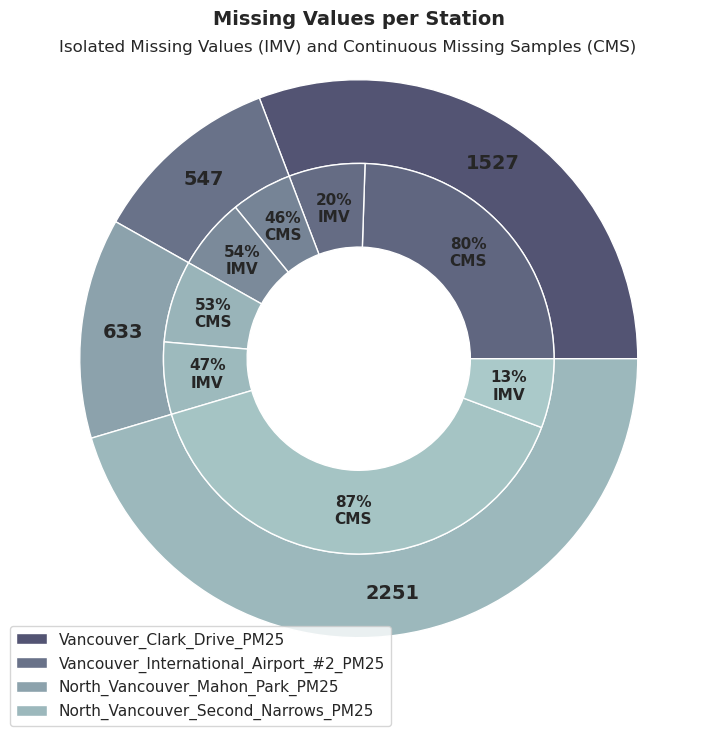

In [11]:
# Continuous missing samples // Isolated missing values count
stations = []
tot_missing = []
stations_cms_imv = []
stations_cms_imv_label = []

for station in pd.unique(master_df["STATION"]):
    stations.append(station)
    tot_missing_current = sum(master_df["MISSING"][master_df["STATION"] == station])
    tot_missing.append(tot_missing_current)
    tot_cms = sum(master_df["MISSING_SAMPLE"][master_df["STATION"] == station])
    stations_cms_imv.append(tot_cms)
    stations_cms_imv_label.append(f"{tot_cms/tot_missing_current * 100:.0f}%\nCMS")
    tot_imv = tot_missing_current - tot_cms
    stations_cms_imv.append(tot_imv)
    stations_cms_imv_label.append(f"{tot_imv/tot_missing_current * 100:.0f}%\nIMV")

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize=(9, 9))
ax.axis("equal")
width = 0.3

cm = plt.get_cmap("bone")
cout = cm([95, 120, 160, 178])
pie, texts1 = ax.pie(
    tot_missing,
    radius=1,
    labels=tot_missing,
    colors=cout,
    labeldistance=0.85,
    textprops={"fontsize": 14, "weight": "bold"},
)
for t in texts1:
    t.set_horizontalalignment("center")
plt.legend(pie, stations, loc=(0, -0.03))
plt.setp(pie, width=width, edgecolor="white")

cin = cm(np.array([110, 115, 135, 140, 175, 180, 188, 193]))
pie2, texts2 = ax.pie(
    stations_cms_imv,
    radius=1 - width,
    labels=stations_cms_imv_label,
    labeldistance=0.78,
    colors=cin,
    textprops={"weight": "bold"},
)
for t in texts2:
    t.set_horizontalalignment("center")
plt.setp(pie2, width=width, edgecolor="white")
plt.title("Missing Values per Station", fontsize=14, weight="bold", y=0.97)
plt.suptitle(
    "Isolated Missing Values (IMV) and Continuous Missing Samples (CMS)",
    fontsize=12,
    y=0.85,
)
plt.show()

## Imputation of Missing Values
* IMV imputation with one-dimensional interpolation
* CMS imputation with LSTM

### Auxiliar Functions to search and plot IMV and CMS

In [12]:
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


In [13]:
master_df["STATION"].unique()

array(['Vancouver_Clark_Drive_PM25',
       'Vancouver_International_Airport_#2_PM25',
       'North_Vancouver_Mahon_Park_PM25',
       'North_Vancouver_Second_Narrows_PM25'], dtype=object)

In [14]:
%load_ext autoreload
%autoreload 2
from tshelpers.subset import subset_interval, create_missing
from tshelpers.plot import plot_sequence, plot_compare
from tshelpers.metrics import rmse_score

In [15]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"]
interval = subset_interval(station_subset, missing_type="IMV", sequence_no=5)

179 IMV missing value sequences found with current arguments:
+-----+---------------------+---------------------+----------+
|     | Sequence Start      | Sequence End        | Length   |
|-----+---------------------+---------------------+----------|
|   0 | 2016-02-04 16:00:00 | 2016-02-04 17:00:00 | 1 h      |
|   1 | 2016-02-17 14:00:00 | 2016-02-17 15:00:00 | 1 h      |
|   2 | 2016-05-25 11:00:00 | 2016-05-25 13:00:00 | 2 h      |
|   3 | 2016-07-08 11:00:00 | 2016-07-08 12:00:00 | 1 h      |
|   4 | 2016-08-09 09:00:00 | 2016-08-09 13:00:00 | 4 h      |
|   5 | 2016-08-10 09:00:00 | 2016-08-10 14:00:00 | 5 h      |
|   6 | 2016-08-12 11:00:00 | 2016-08-12 14:00:00 | 3 h      |
|   7 | 2016-09-01 16:00:00 | 2016-09-01 18:00:00 | 2 h      |
|   8 | 2016-09-03 12:00:00 | 2016-09-03 14:00:00 | 2 h      |
|   9 | 2016-09-03 16:00:00 | 2016-09-03 17:00:00 | 1 h      |
|  10 | 2016-09-08 11:00:00 | 2016-09-08 13:00:00 | 2 h      |
|  11 | 2016-09-08 14:00:00 | 2016-09-08 15:00:00 | 1 h 

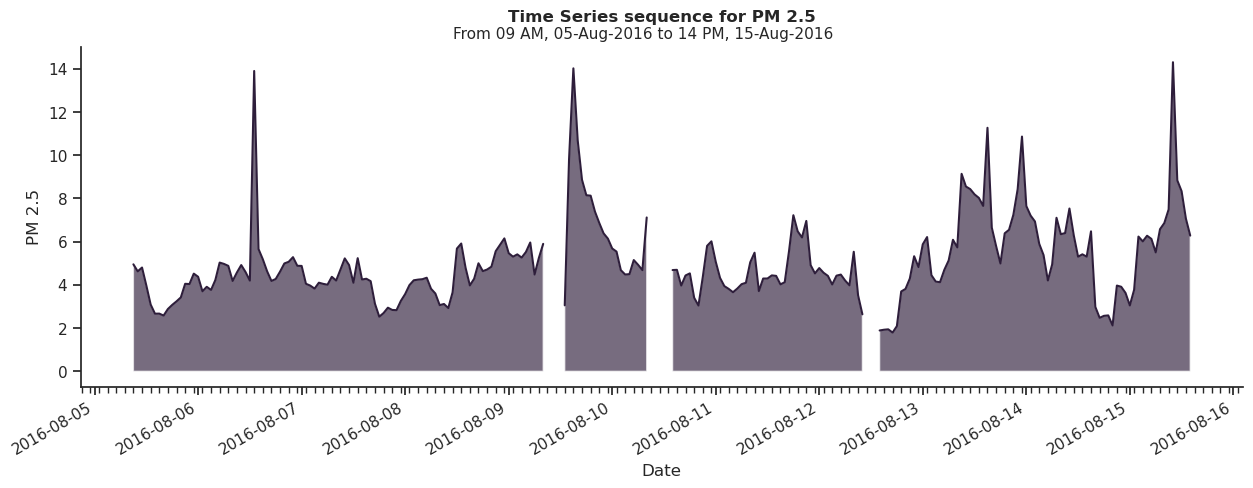

In [17]:
plot_sequence(data=station_subset, value="PM 2.5", start=interval[0], end=interval[1])

### Generating Artificial Missing Data
Artificially missing data will be generated to evaluate imputation methods

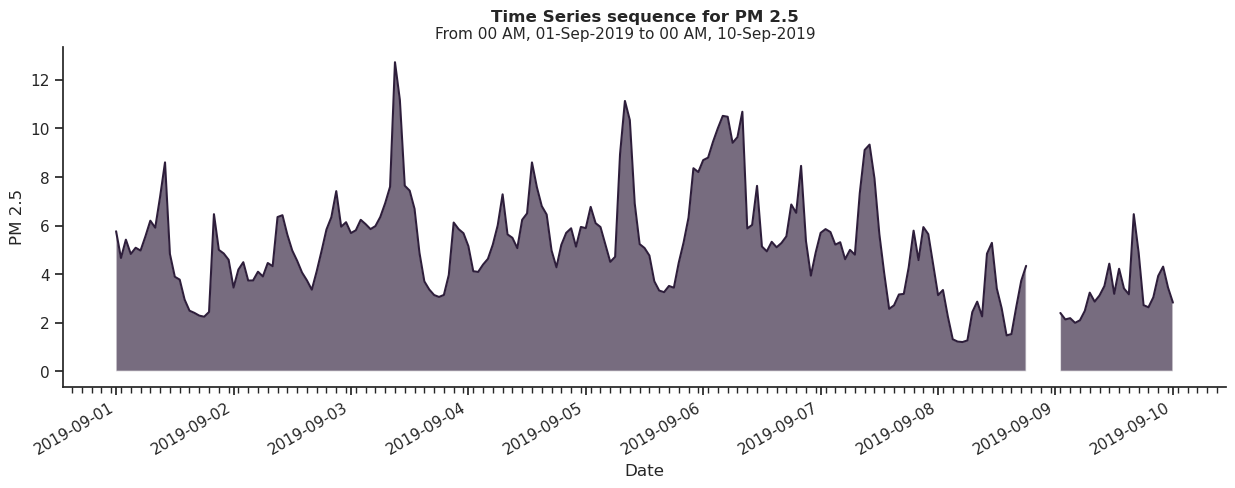

In [18]:
subset, subset_missing = create_missing(
    data=station_subset,
    value="PM 2.5",
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    missing_length=6,
    padding=24,
    missing_index="end",
)

plot_sequence(data=subset_missing, value="PM 2.5")

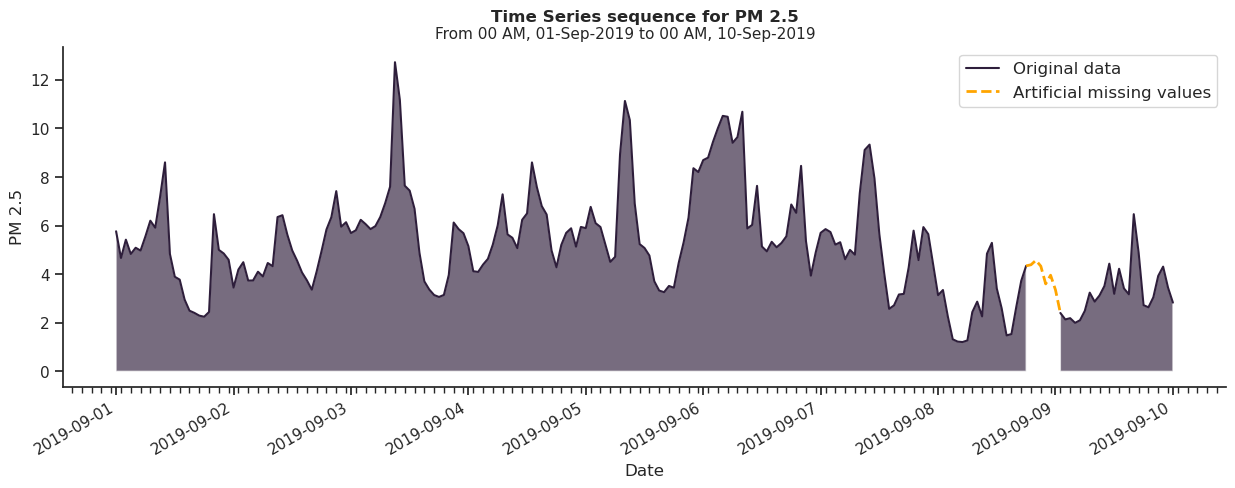

In [19]:
plot_compare(
    subset,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    fill=True,
    data_label="Artificial missing values",
    data_missing_label="Original data",
)

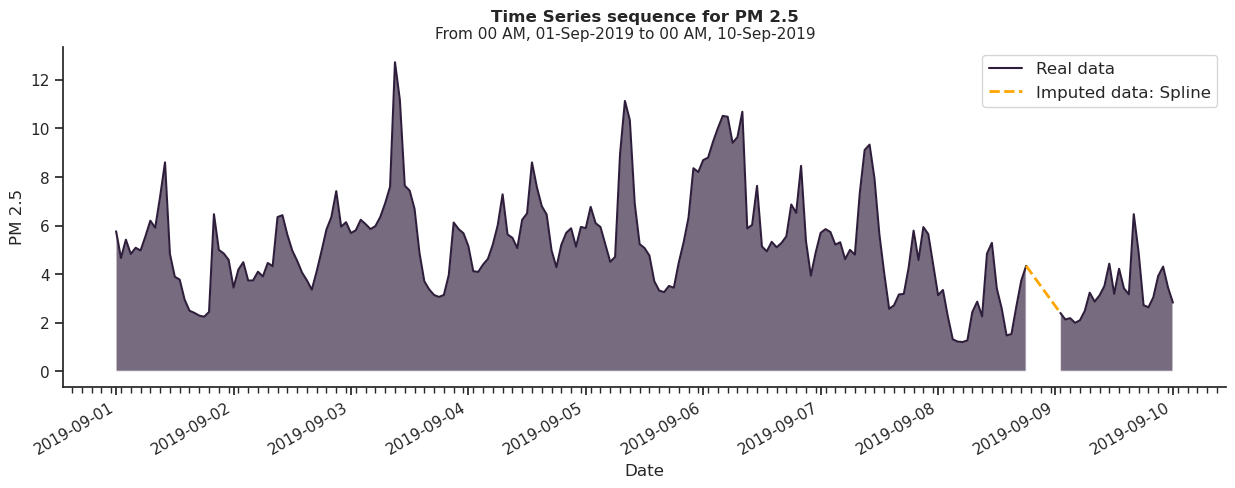

RMSE for PM 2.5: 0.1172


In [20]:
subset_imputed = subset.copy()
subset_imputed["PM 2.5"] = (
    subset_missing["PM 2.5"].interpolate(method="linear").tolist()
)
plot_compare(
    subset_imputed,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    data_label="Imputed data: Spline",
)

_ = rmse_score(subset, subset_imputed, value="PM 2.5")

### Subsetting intervals for experimentation
Defining candidate subsets to experiment with imputation methods

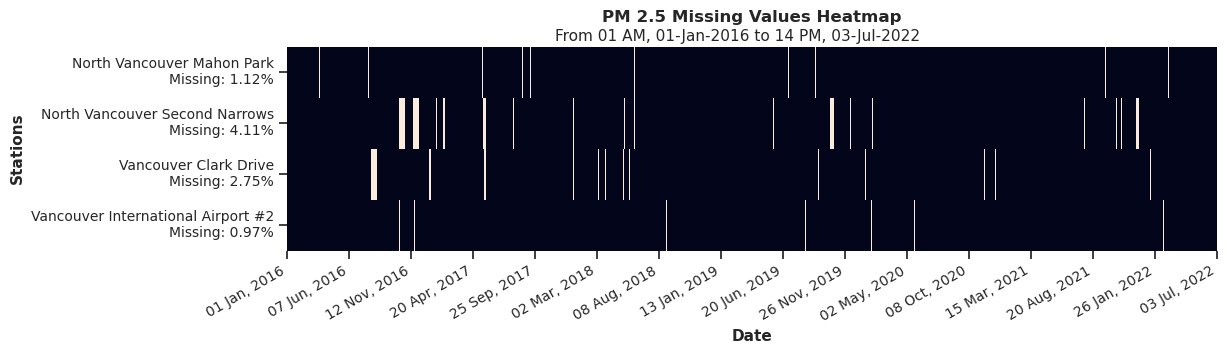

In [21]:
from tshelpers.plot import plot_missing
plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"))

In [22]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"]
interval = subset_interval(station_subset, missing_type="CMS", sequence_no=0)

20 CMS missing value sequences found with current arguments:
+----+---------------------+---------------------+----------+
|    | Sequence Start      | Sequence End        | Length   |
|----+---------------------+---------------------+----------|
|  0 | 2016-03-23 11:00:00 | 2016-03-24 01:00:00 | 14 h     |
|  1 | 2016-07-26 11:00:00 | 2016-07-27 00:00:00 | 13 h     |
|  2 | 2016-08-17 11:00:00 | 2016-08-18 14:00:00 | 27 h     |
|  3 | 2017-05-12 05:00:00 | 2017-05-14 19:00:00 | 62 h     |
|  4 | 2017-05-17 13:00:00 | 2017-05-18 12:00:00 | 23 h     |
|  5 | 2017-07-07 19:00:00 | 2017-07-08 10:00:00 | 15 h     |
|  6 | 2017-09-13 14:00:00 | 2017-09-13 21:00:00 | 7 h      |
|  7 | 2018-06-23 04:00:00 | 2018-06-23 13:00:00 | 9 h      |
|  8 | 2018-11-04 15:00:00 | 2018-11-05 03:00:00 | 12 h     |
|  9 | 2019-03-10 07:00:00 | 2019-03-10 15:00:00 | 8 h      |
| 10 | 2019-05-27 14:00:00 | 2019-05-28 05:00:00 | 15 h     |
| 11 | 2019-07-03 08:00:00 | 2019-07-05 00:00:00 | 40 h     |
| 12 | 20

## Imputation of short sequences
* Short sequences are defined as the ones with two or less subsequent data points missing
* Testing between spline and linear imputation

In [23]:
# Looking for months without missing values
for station in stations:
    station_subset = master_df[master_df["STATION"] == station]
    print(f"Complete months in station {station}:")
    for year in range (2016, 2022):
        if year == 2022:
            range_max = 7
        else:
            range_max = 13
        for month in range(1, range_max):
            if month == 12:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month, 31, 23)]
            else:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month+1, 1)]
            if subset['PM 2.5'].isna().sum() == 0:
                print(f"{month}-{year}")

Complete months in station Vancouver_Clark_Drive_PM25:
4-2016
10-2016
2-2019
Complete months in station Vancouver_International_Airport_#2_PM25:
4-2016
7-2016
4-2019
Complete months in station North_Vancouver_Mahon_Park_PM25:
1-2016
4-2016
6-2016
6-2017
2-2018
Complete months in station North_Vancouver_Second_Narrows_PM25:
2-2016
6-2016
7-2016
3-2017
4-2017
9-2017
2-2019
4-2019
6-2019


## Experimentation subsets
* Vancouver Clark Drive
    * 4-2016 and 2-2019
* Vancouver International Airport:
    * 4-2016 and 4-2019
* North Vancouver Mahon Park:
    * 6-2016 and 6-2017
* North Vancouver Second Narrows:
    * 2-2016, 6-2016, 4-2017, 9-2017, 4-2019, and 6-2019

In [26]:
# Experimental subsets
exp_subsets = {
    "Vancouver_Clark_Drive_PM25": {
        "4-2016": master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][datetime(2016, 4, 1):datetime(2016, 5, 1)],
        "2-2019": master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][datetime(2019, 2, 1):datetime(2019, 3, 1)],
    },
    "Vancouver_International_Airport_#2_PM25": {
        "4-2016": master_df[master_df["STATION"] == "Vancouver_International_Airport_#2_PM25"][datetime(2016, 4, 1):datetime(2016, 5, 1)],
        "4-2019": master_df[master_df["STATION"] == "Vancouver_International_Airport_#2_PM25"][datetime(2019, 4, 1):datetime(2019, 5, 1)],
    },
    "North_Vancouver_Mahon_Park_PM25": {
        "6-2016": master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][datetime(2016, 6, 1):datetime(2016, 7, 1)],
        "6-2017": master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][datetime(2017, 6, 1):datetime(2017, 7, 1)],
    },
    "North_Vancouver_Second_Narrows_PM25": {
        "2-2016": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2016, 2, 1):datetime(2016, 3, 1)],
        "6-2016": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2016, 6, 1):datetime(2016, 7, 1)],
        "4-2017": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2017, 4, 1):datetime(2017, 5, 1)],
        "9-2017": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2017, 9, 1):datetime(2017, 10, 1)],
        "4-2019": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2019, 4, 1):datetime(2019, 5, 1)],
        "6-2019": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2019, 6, 1):datetime(2019, 7, 1)],
    }
}

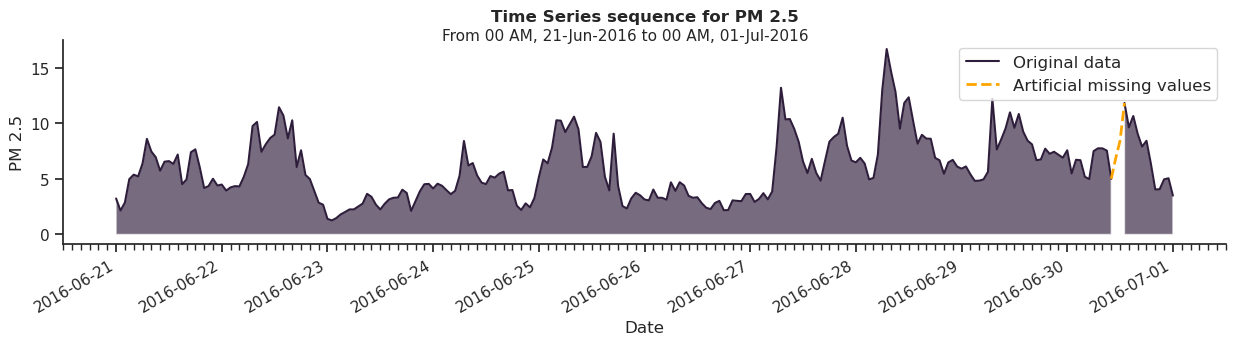

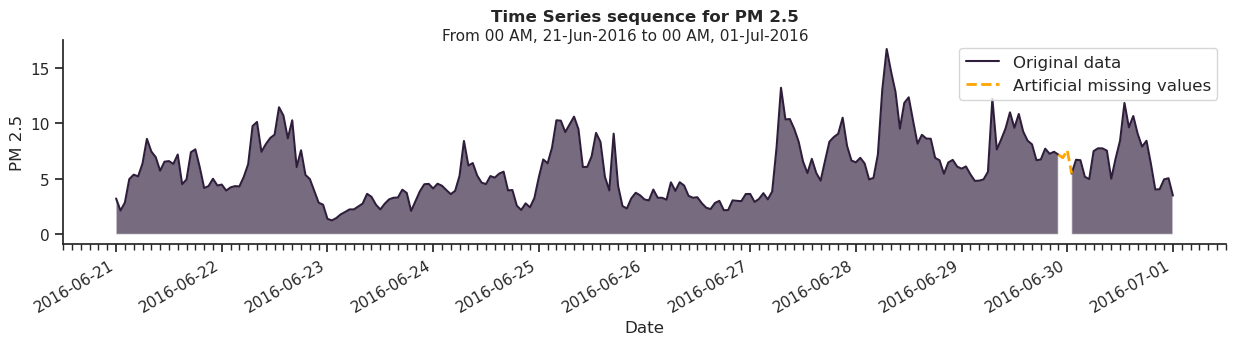

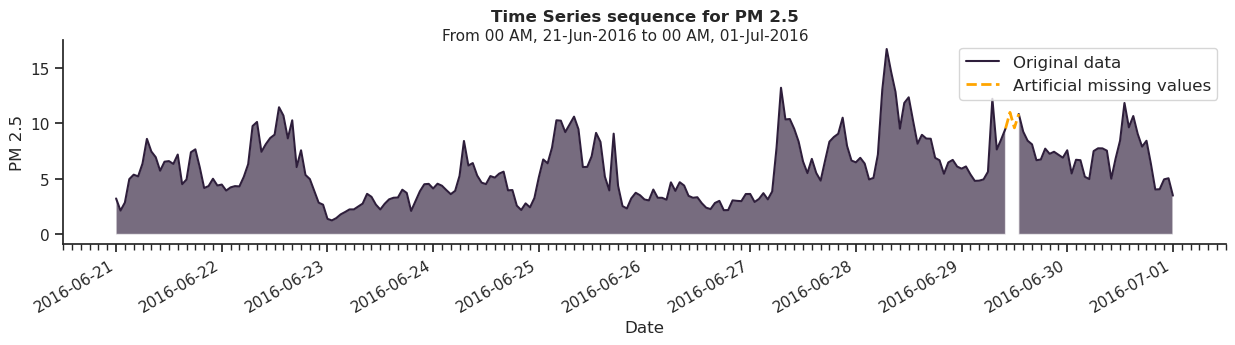

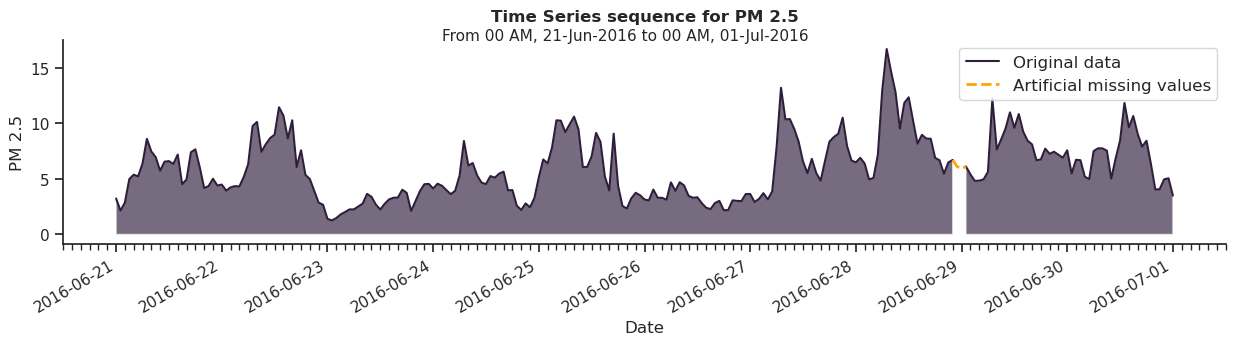

In [24]:
# Implementation example iterating through different paddings:
paddings = [12, 24, 36, 48]

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=2,
        padding=padding,
        missing_index="end",
    )
    plot_compare(
        subset,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Artificial missing values",
        data_missing_label="Original data",
        figsize=(15, 3)
    )

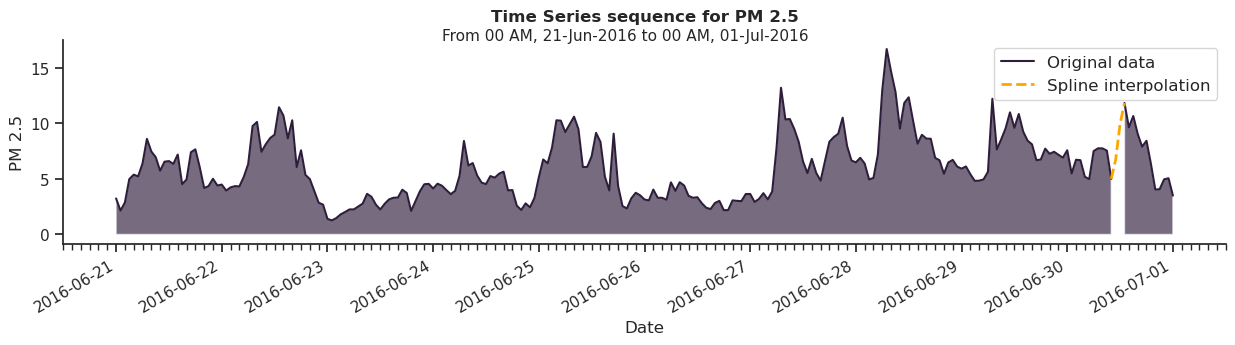

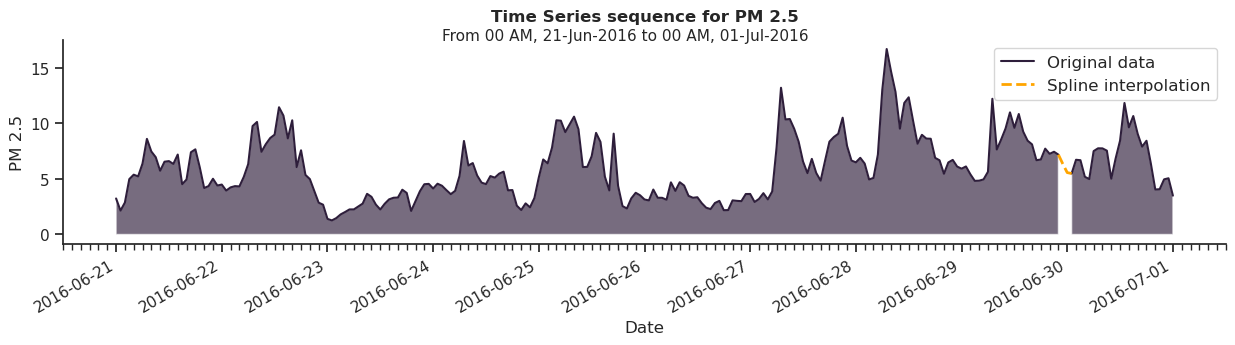

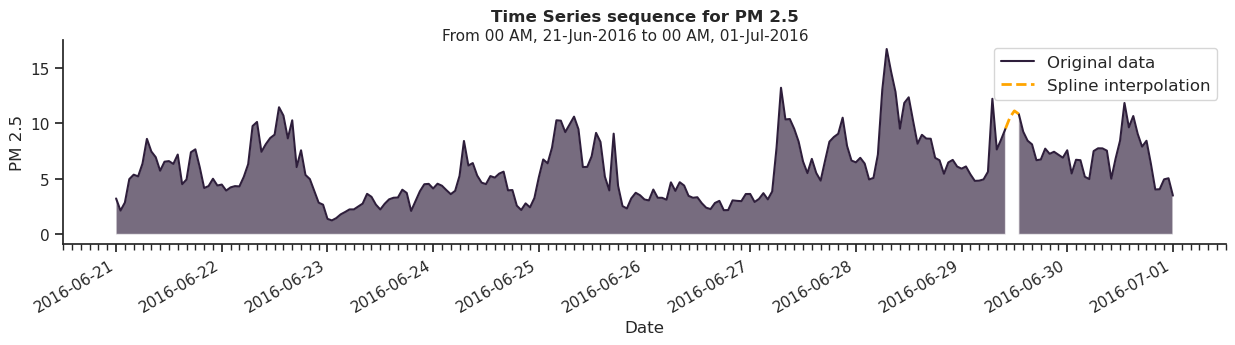

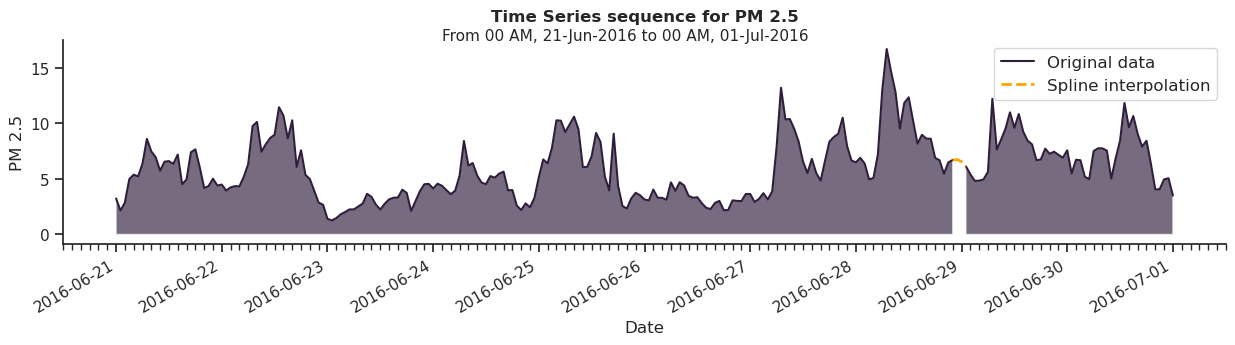

In [25]:
# Implementation example with spline interpolation:
pd.options.mode.chained_assignment = None
from scipy import interpolate

paddings = [12, 24, 36, 48]

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=2,
        padding=padding,
        missing_index="end",
    )

    subset_spline = subset.copy()
    # Indexing missing values
    missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

    # Indexing boundary values at t-2, t-1, t+1, and t+2
    boundary_idx = []
    for idx in range(min(missing_idx)-2, max(missing_idx)+3):
        if idx not in missing_idx:
            boundary_idx.append(idx)
    boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

    # Fitting cubic spline
    cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
    imputed = interpolate.splev(missing_idx, cubic_spline)

    subset_spline["PM 2.5"][missing_idx] = imputed

    plot_compare(
        subset_spline,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Spline interpolation",
        data_missing_label="Original data",
        figsize=(15, 3)
    )

>Ref.: _Carl de Boor, “A Practical Guide to Splines”, Springer-Verlag, 1978._

In [46]:
for station in tqdm(exp_subsets):
    for station_subset in tqdm(exp_subsets[station]):
        imputation_step = str(station + "_" + station_subset)
        print(imputation_step, type(imputation_step))
        # print(station)
        # display(exp_subsets[station][station_subset].head(2))
        # break

100%|██████████| 2/2 [00:00<00:00, 19284.16it/s]


Vancouver_Clark_Drive_PM25_4-2016 <class 'str'>
Vancouver_Clark_Drive_PM25_2-2019 <class 'str'>


100%|██████████| 2/2 [00:00<00:00, 15563.28it/s]


Vancouver_International_Airport_#2_PM25_4-2016 <class 'str'>
Vancouver_International_Airport_#2_PM25_4-2019 <class 'str'>


100%|██████████| 2/2 [00:00<00:00, 17697.49it/s]


North_Vancouver_Mahon_Park_PM25_6-2016 <class 'str'>
North_Vancouver_Mahon_Park_PM25_6-2017 <class 'str'>


100%|██████████| 4/4 [00:00<00:00, 342.61it/s]

North_Vancouver_Second_Narrows_PM25_2-2016 <class 'str'>
North_Vancouver_Second_Narrows_PM25_6-2016 <class 'str'>
North_Vancouver_Second_Narrows_PM25_4-2017 <class 'str'>
North_Vancouver_Second_Narrows_PM25_9-2017 <class 'str'>
North_Vancouver_Second_Narrows_PM25_4-2019 <class 'str'>
North_Vancouver_Second_Narrows_PM25_6-2019 <class 'str'>


In [71]:
# Iterate through stations, then subsets to evaluate linear interpolation vs. cubic spline
from tqdm import tqdm

'''
Iterate through stations
Iterate through subsets
Step backwards with artifficial missing values
Impute cubic spline and evaluate RMSE
'''
# One hour paddings for a complete month
paddings = [i for i in range(12, 30*24-70)]
create_missing_args = {
    "value": "PM 2.5",
    "missing_index": "end"
}

imputation_results = {}
# for station in (pbar := tqdm(exp_subsets)):
for station in exp_subsets:
    # pbar.set_description(f"Processing station {station}...")
    # for station_subset in (pbar := tqdm(exp_subsets[station])):
    for station_subset in exp_subsets[station]:
        # pbar.set_description(f"Processing subset {station_subset}...")
        imputation_step = str(station + "_" + station_subset)
        imputation_results[imputation_step] = {}
        imputation_results[imputation_step]["RMSE_Cubic_2h"] = []
        imputation_results[imputation_step]["RMSE_Linear_2h"] = []
        print(f"Subset {station_subset} for station {station} starting with missing_idx: {missing_idx} and padding {padding}")
        for padding in paddings:
            # Creating missing interval with length = 2
            subset, subset_missing = create_missing(
                **create_missing_args,
                data=exp_subsets[station][station_subset],
                padding=padding,
                missing_length=2
            )
            ### Cubic spline
            subset_spline = subset.copy()
            missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()
            print(missing_idx)
            # Indexing boundary values at t-2, t-1, t+1, and t+2
            boundary_idx = []
            for idx in range(min(missing_idx)-2, max(missing_idx)+3):
                if idx not in missing_idx:
                    boundary_idx.append(idx)
            boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

            # Fitting cubic spline
            cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
            imputed = interpolate.splev(missing_idx, cubic_spline)
            subset_spline["PM 2.5"][missing_idx] = imputed

            # Evaluating cubic spline
            rmse_cubic_2h = rmse_score(subset, subset_spline, value="PM 2.5", verbose=False)
            imputation_results[imputation_step]["RMSE_Cubic_2h"].append(rmse_cubic_2h)

            ### Linear interpolation
            subset_linear = subset.copy()
            subset_linear["PM 2.5"] = subset_missing["PM 2.5"].interpolate(method="linear", inplace=False).tolist()

            # Evaluating linear interpolation
            rmse_linear_2h = rmse_score(subset, subset_linear, value="PM 2.5", verbose=False)
            imputation_results[imputation_step]["RMSE_Linear_2h"].append(rmse_linear_2h)
        print(f"Subset {station_subset} for station {station} finished with missing_idx: {missing_idx} and padding {padding}")

Subset 4-2016 for station Vancouver_Clark_Drive_PM25 starting with missing_idx: [] and padding 673
[707, 708]
[706, 707]
[705, 706]
[704, 705]
[703, 704]
[702, 703]
[701, 702]
[700, 701]
[699, 700]
[698, 699]
[697, 698]
[696, 697]
[695, 696]
[694, 695]
[693, 694]
[692, 693]
[691, 692]
[690, 691]
[689, 690]
[688, 689]
[687, 688]
[686, 687]
[685, 686]
[684, 685]
[683, 684]
[682, 683]
[681, 682]
[680, 681]
[679, 680]
[678, 679]
[677, 678]
[676, 677]
[675, 676]
[674, 675]
[673, 674]
[672, 673]
[671, 672]
[670, 671]
[669, 670]
[668, 669]
[667, 668]
[666, 667]
[665, 666]
[664, 665]
[663, 664]
[662, 663]
[661, 662]
[660, 661]
[659, 660]
[658, 659]
[657, 658]
[656, 657]
[655, 656]
[654, 655]
[653, 654]
[652, 653]
[651, 652]
[650, 651]
[649, 650]
[648, 649]
[647, 648]
[646, 647]
[645, 646]
[644, 645]
[643, 644]
[642, 643]
[641, 642]
[640, 641]
[639, 640]
[638, 639]
[637, 638]
[636, 637]
[635, 636]
[634, 635]
[633, 634]
[632, 633]
[631, 632]
[630, 631]
[629, 630]
[628, 629]
[627, 628]
[626, 627]

In [72]:
imputation_results.keys()

dict_keys(['Vancouver_Clark_Drive_PM25_4-2016', 'Vancouver_Clark_Drive_PM25_2-2019', 'Vancouver_International_Airport_#2_PM25_4-2016', 'Vancouver_International_Airport_#2_PM25_4-2019', 'North_Vancouver_Mahon_Park_PM25_6-2016', 'North_Vancouver_Mahon_Park_PM25_6-2017', 'North_Vancouver_Second_Narrows_PM25_2-2016', 'North_Vancouver_Second_Narrows_PM25_6-2016', 'North_Vancouver_Second_Narrows_PM25_4-2017', 'North_Vancouver_Second_Narrows_PM25_9-2017', 'North_Vancouver_Second_Narrows_PM25_4-2019', 'North_Vancouver_Second_Narrows_PM25_6-2019'])

<AxesSubplot: >

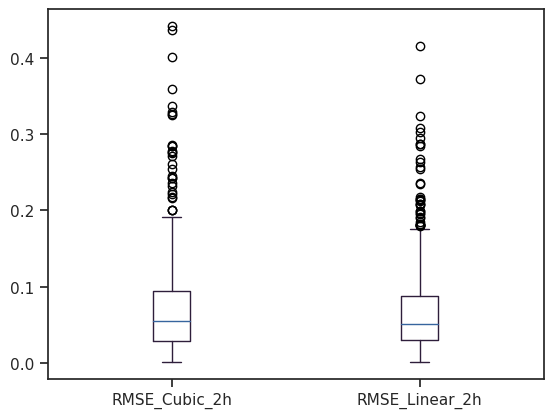

In [81]:
pd.DataFrame(imputation_results["Vancouver_Clark_Drive_PM25_4-2016"]).plot(kind="box")

<AxesSubplot: >

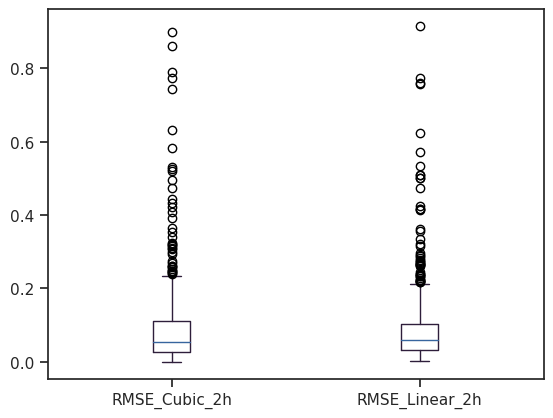

In [80]:
pd.DataFrame(imputation_results["Vancouver_Clark_Drive_PM25_2-2019"]).plot(kind="box")